## The VGG16 model development and fine tuning

in this notebook we will load and add our layers to the base model of the pre-trained VGG16 model, and fine tune the following components of the model:
1. **Optimizers** - We will use only 5 optimizers to see which one works best, namely; 1. `SGD`,2. `RMSprop`,3. `Adam`,4. `Adagrad`,5. `Adadelta`. the best optimizer will be used in the New model
2. **Number of epochs** - We will also use only 4 epochs to choose the best performer namely; `1, 2, 5, 10`.
3. **Batch size** - we will also use these batch sizes to choose the optimum batch size, namely; `8, 16`. 
4. **Dropout value** - we will then use these dropout values to choose the optimum dropout value, namely; `0.5, 0.6, 0.7, 0.8, 0.9`

> **Section one:** we will create common function and also create our base model, with the following initial parameters: **Batch size** `8`, **Optimizer** `Adam`, **Number of epochs** `5`, 

# **Import libraries that we will use**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import cv2
import random
from keras_preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
import time
import tqdm.gui as tqdm
import tqdm.notebook as tqdm

# **Common functions**

In [ ]:

def get_data_generator(train_data_path, \
                       val_data_path, \
                       targetsize, \
                       classmode, \
                       batchsize):
    """
    This function is a data generator function for train, validation
    Inputs
        train_data_path   : train data path for the dataset 
        val_data_path     : validation data path for the dataset
        targetsize        : target size for the generator to resize all images to, (224,224)
        classmode         : class mode, 'categorical'
        batchsize         : batch size
    Outputs
        train_generator   : generated train data
        val_generator   : generated train data
    
    """
    train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    
    train_generator=train_datagen.flow_from_directory(train_data_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize,
                                                 color_mode='rgb',
                                                 batch_size=batchsize,
                                                 class_mode=classmode,
                                                 shuffle=True)
    
    val_generator=val_datagen.flow_from_directory(val_data_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize,
                                                 color_mode='rgb',
                                                 batch_size=batchsize,
                                                 class_mode=classmode,
                                                 shuffle=True)
    return train_generator,val_generator   



def train_evaluate_the_model(train_generator, \
                            val_generator, \
                            optimizer, \
                            epochs, \
                            dropout_value, \
                            TheModel):
    '''
    train the model, do predictions, and do evaluation and return the accuracy of the model
    Inputs
        train_generator : generated train data
        val_generator   : generated validation data
        optimizer       : the optimizer method used to compile the model
        epochs          : the epochs of the model use to fit the model
        TheModel        : The pretrained model loaded,
    Outputs
        accuracy        : The accuracy of the model
    '''
    # load pretrained model and add layers on top of the model
    x = TheModel.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_value)(x)
    preds = Dense(4,activation='softmax')(x)
    model = Model(inputs = TheModel.input,outputs=preds)
    
    # freeze base layers for training
    for layer in TheModel.layers:
        layer.trainable = False
    
    # compile the model
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    step_size_train=train_generator.n//train_generator.batch_size
    # fit the model
    r = model.fit_generator(generator=train_generator,
                        validation_data=val_generator,
                        steps_per_epoch=step_size_train,
                        epochs=epochs)
    # valuate the model
    scores = model.evaluate(val_generator)
    accuracy = scores[1]*100
    
    return accuracy, model

## **Explore the preprocess_input function**

## The preprocess_input function will be used to preprocess the images so that they can be ready to be fed into the models.

In [ ]:
Gli_images=os.listdir("/content/drive/MyDrive/Capstone-Project/Training/Glioma/")

imgs=[]
for i in range(len(Gli_images)):
    img=load_img(Gli_images[i]) 
    imgs.append(img)


In [ ]:
z=random.randint(1,len(imgs))
im = img_to_array(imgs[z])
print("Maximum pixel value before preprocessing: ",im.max())

Maximum pixel value before preprocessing:  255.0


In [ ]:
im = preprocess_input(im)
print("Maxium pixel value after pre-processing :",im.max())

Maxium pixel value after pre-processing : 151.061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Preprocessed Image')

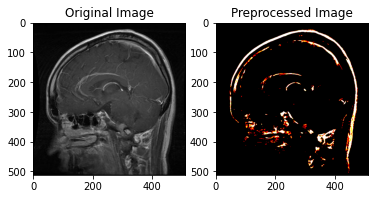

In [ ]:
z=random.randint(1,len(imgs))
im = img_to_array(imgs[z])
im = np.expand_dims(im, axis=0)
im = preprocess_input(im)

plt.subplot(1,2,1)
plt.imshow(imgs[z])
plt.title("Original Image")
        
        
plt.subplot(1,2,2)
im=np.reshape(im,(im.shape[1],im.shape[2],im.shape[3]))
plt.imshow(im)
plt.title("Preprocessed Image")

# **Load and generate data**

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

'''
Initial and constant parameters for the model
initial parameters
       batch_size    : the initial batch size we will create our base model with
Constant parameters
       target_size   : Constant image target size for the whole notebook which is (224,224)
       class_mode    : class mode we will use for the whole notebook, which is 'categorical'
'''
# constant parameters
targetsize_constant = (224,224)
classmode_constant = 'categorical'

# initial parameters
batchsize_initial = 8
epochs_initial = 4
dropout_value_initial = 0.5
optimizer_initial = 'Adam'

# Data paths
train_dataset_path = 'Dataset/Training/'
validation_dataset_path = 'Dataset/Validation/'



train_generator_initial = train_datagen.flow_from_directory(train_dataset_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize_constant,
                                                 color_mode='rgb',
                                                 batch_size=batchsize_initial,
                                                 class_mode=classmode_constant,
                                                 shuffle=True)
val_generator_initial = val_datagen.flow_from_directory(validation_dataset_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize_constant,
                                                 color_mode='rgb',
                                                 batch_size=batchsize_initial,
                                                 class_mode=classmode_constant,
                                                 shuffle=True)


Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
# display classes found in the data
train_generator_initial.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

#### Import the VGG16 base model

In [ ]:
image_size = [224,224] # choose image size
# import the base model
vgg = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False)


# **Add layers on top of the base model**

In [ ]:
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(4,activation='softmax')(x)
model = Model(inputs = vgg.input,outputs=preds)

In [ ]:
# freeze base layers for training
for layer in vgg.layers:
    layer.trainable = False

# **Compile the model**

In [ ]:
# initial optimizer
optimizer_initial = 'Adam'

# compile the model
model.compile(optimizer=optimizer_initial,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **Fit the model**

In [ ]:
# initial parameters
epochs_initial = 5
step_size_train_initial=train_generator_initial.n//train_generator_initial.batch_size # computing the steps size per epoch

tic = time.time()
# fit the model
r = model.fit_generator(generator=train_generator_initial,
                        validation_data=val_generator_initial,
                        steps_per_epoch=step_size_train_initial,
                        epochs=epochs_initial)

toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

C:\Users\Student\anaconda_3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
358/358 [==============================] - 932s 3s/step - loss: 0.7073 - accuracy: 0.7491 - val_loss: 0.4140 - val_accuracy: 0.8334
Epoch 2/5
358/358 [==============================] - 941s 3s/step - loss: 0.3818 - accuracy: 0.8557 - val_loss: 0.2514 - val_accuracy: 0.9056
Epoch 3/5
358/358 [==============================] - 949s 3s/step - loss: 0.2920 - accuracy: 0.8945 - val_loss: 0.2006 - val_accuracy: 0.9362
Epoch 4/5
358/358 [==============================] - 957s 3s/step - loss: 0.2659 - accuracy: 0.9001 - val_loss: 0.1971 - val_accuracy: 0.9373
Epoch 5/5
358/358 [==============================] - 968s 3s/step - loss: 0.2071 - accuracy: 0.9186 - val_loss: 0.2009 - val_accuracy: 0.9289


# **Evaluate the model**

In [ ]:
# evaluation on validation data
scores = model.evaluate(val_generator_initial)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

#scores = model.evaluate_generator(val_generator)
#print("%s%s: %.2f%%" % ("evaluate_generator ",model.metrics_names[1], scores[1]*100))

359/359 [==============================] - 471s 1s/step - loss: 0.2009 - accuracy: 0.9289
evaluate accuracy: 92.89%


# **Section two:** We will start fine tunning
## **Tunning optimizers of the model**

In [ ]:
TheBaseModel = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False) # load a clean base model

param_label = 'optimizer'
param_list = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta'] # ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta']

accuracy_table = {param_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    # Train, predict and evaluate model
    accuracy, _ = train_evaluate_the_model(train_generator_initial,val_generator_initial,param,epochs_initial,TheBaseModel) # replace epochs with 'epochs_initial'
    
    # Collect results
    accuracy_table[param_label].append(param)
    accuracy_table['accuracy'].append(accuracy)
    
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

Epoch 1/5
358/358 [==============================] - 938s 3s/step - loss: 0.7257 - accuracy: 0.7530 - val_loss: 0.3804 - val_accuracy: 0.8460
Epoch 2/5
358/358 [==============================] - 933s 3s/step - loss: 0.3693 - accuracy: 0.8592 - val_loss: 0.3186 - val_accuracy: 0.8774
Epoch 3/5
358/358 [==============================] - 932s 3s/step - loss: 0.3001 - accuracy: 0.8823 - val_loss: 0.1630 - val_accuracy: 0.9373
Epoch 4/5
358/358 [==============================] - 932s 3s/step - loss: 0.2670 - accuracy: 0.9018 - val_loss: 0.1885 - val_accuracy: 0.9376
Epoch 5/5
359/359 [==============================] - 467s 1s/step - loss: 0.1324 - accuracy: 0.9505
Epoch 1/5
358/358 [==============================] - 938s 3s/step - loss: 0.6824 - accuracy: 0.7568 - val_loss: 0.4280 - val_accuracy: 0.8073
Epoch 2/5
358/358 [==============================] - 937s 3s/step - loss: 0.3185 - accuracy: 0.8756 - val_loss: 0.2820 - val_accuracy: 0.8815
Epoch 3/5
358/358 [=============================

,optimizer,accuracy
0,Adam,95.052266
1,SGD,98.118466
2,RMSprop,93.937284
3,Adagrad,97.735190
4,Adadelta,76.202089


Text(0, 0.5, 'accuracy)')

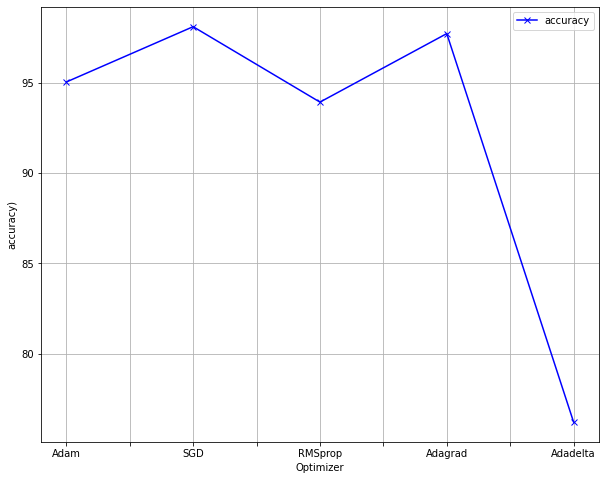

In [ ]:
from pylab import rcParams

# plot results
rcParams['figure.figsize'] = 10,8 # width 10, height 8

ax = accuracy_table.plot(x='optimizer', y='accuracy',style='bx-', grid=True)
#ax.set_xticklabels(param_list) # gave me an error when used
ax.set_xlabel("Optimizer")
ax.set_ylabel("accuracy)")

In [ ]:
# Get optimum value for param
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
optimizer_opt = temp[param_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(optimizer_opt))

max Accuracy = 98.118
optimum optimizer = SGD


# **Tuning batch size and epochs of the model**

In [ ]:
TheBaseModel = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False) # load a clean base model

param_label = 'epochs'
param_list = [1,2,5,10] # [5, 10, 15, 20]

param2_label = 'batch_size'
param2_list = [8, 16] # [8, 16, 32] am using this batch sizes for now until we fix the accuracy issue, proper batch sizes to be use [8, 16, 32, 64, 128]

accuracy_table = {param_label: [], param2_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    for param2 in tqdm_notebook(param2_list):
        
        # generate train and validation data
        train_generator,val_generator, _ = get_data_generator(train_dataset_path,validation_dataset_path,test_dataset_path, targetsize_constant, classmode_constant, param2)
        # train, predict and evaluate model
        accuracy, _ = train_evaluate_the_model(train_generator, val_generator, optimizer_initial, param, TheBaseModel)
        
        # collect results
        accuracy_table[param_label].append(param)
        accuracy_table[param2_label].append(param2)
        accuracy_table['accuracy'].append(accuracy)
        
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

<ipython-input-15-d9397eb64c7a>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


C:\Users\Student\anaconda_3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


359/359 [==============================] - 472s 1s/step - loss: 0.3878 - accuracy: 0.8613
Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
180/180 [==============================] - 469s 3s/step - loss: 0.3191 - accuracy: 0.8847



Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/2
358/358 [==============================] - 946s 3s/step - loss: 0.7618 - accuracy: 0.7338 - val_loss: 0.3760 - val_accuracy: 0.8707
Epoch 2/2
359/359 [==============================] - 474s 1s/step - loss: 0.2769 - accuracy: 0.9014
Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/2
179/179 [==============================] - 944s 5s/step - loss: 0.9406 - accuracy: 0.7376 - val_loss: 0.2830 - val_accuracy: 0.8969
Epoch 2/2
180/180 [==============================] - 473s 3s/step - loss: 0.3030 - accuracy: 0.8850



Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/5
358/358 [==============================] - 950s 3s/step - loss: 0.7569 - accuracy: 0.7481 - val_loss: 0.2794 - val_accuracy: 0.9017
Epoch 2/5
358/358 [==============================] - 949s 3s/step - loss: 0.3460 - accuracy: 0.8711 - val_loss: 0.2920 - val_accuracy: 0.8997
Epoch 3/5
358/358 [==============================] - 949s 3s/step - loss: 0.2844 - accuracy: 0.9008 - val_loss: 0.2848 - val_accuracy: 0.8704
Epoch 4/5
358/358 [==============================] - 948s 3s/step - loss: 0.2190 - accuracy: 0.9228 - val_loss: 0.1450 - val_accuracy: 0.9432
Epoch 5/5
359/359 [==============================] - 475s 1s/step - loss: 0.1211 - accuracy: 0.9669
Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/5
179/179 [==============================] - 939s 5s/step - loss: 0.8689 -

Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/10
358/358 [==============================] - 957s 3s/step - loss: 0.7263 - accuracy: 0.7582 - val_loss: 0.3282 - val_accuracy: 0.8686
Epoch 2/10
358/358 [==============================] - 957s 3s/step - loss: 0.3385 - accuracy: 0.8679 - val_loss: 0.2816 - val_accuracy: 0.8962
Epoch 3/10
358/358 [==============================] - 958s 3s/step - loss: 0.2682 - accuracy: 0.8920 - val_loss: 0.3231 - val_accuracy: 0.8760
Epoch 4/10
358/358 [==============================] - 957s 3s/step - loss: 0.2114 - accuracy: 0.9186 - val_loss: 0.1708 - val_accuracy: 0.9314
Epoch 5/10
358/358 [==============================] - 969s 3s/step - loss: 0.2160 - accuracy: 0.9252 - val_loss: 0.1075 - val_accuracy: 0.9648
Epoch 6/10
358/358 [==============================] - 958s 3s/step - loss: 0.1790 - accuracy: 0.9343 - val_loss: 0.1111 - val_accuracy: 0.9564
Epoch 7/10
358/35

,epochs,batch_size,accuracy
0,1,8,86.132401
1,1,16,88.466901
2,2,8,90.139371
3,2,16,88.501740
4,5,8,96.689898
5,5,16,96.480834
6,10,8,96.236932
7,10,16,93.832755


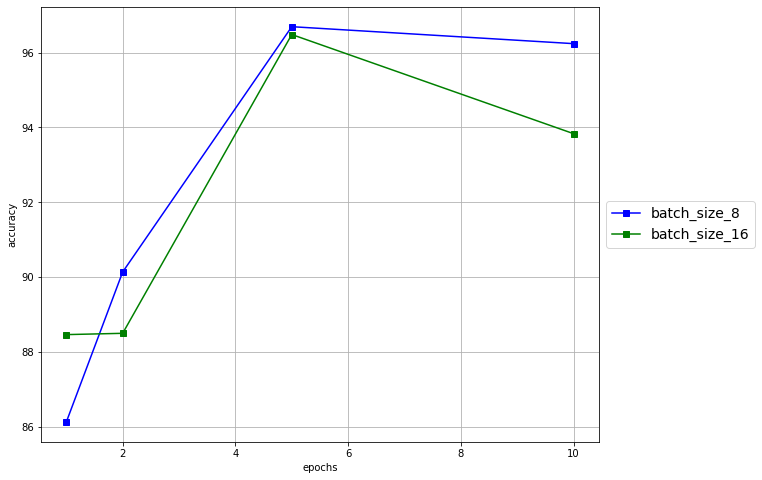

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = accuracy_table[accuracy_table[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='accuracy', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', '0.75']
for i in range(1,len(param2_list)):
    temp = accuracy_table[accuracy_table[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='accuracy', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("accuracy")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure


In [ ]:
# Get optimum value for param and param2
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

max Accuracy = 96.690
optimum epochs = 5
optimum batch_size = 8


# **Tunning dropout of the model**

In [ ]:
param_label = 'dropout_prob'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9]

TheBaseModel = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False) # load a clean base model

accuracy_table = {param_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    # Train, predict and evaluate model
    accuracy, _ = train_evaluate_the_model(train_generator_initial,val_generator_initial,optimizer_initial,epochs_initial,param,TheBaseModel) # replace epochs with 'epochs_initial'
    
    # Collect results
    accuracy_table[param_label].append(param)
    accuracy_table['accuracy'].append(accuracy)
    
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

C:\Users\Student\anaconda_3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
358/358 [==============================] - 1136s 3s/step - loss: 0.8254 - accuracy: 0.7324 - val_loss: 0.4870 - val_accuracy: 0.8007
Epoch 2/4
358/358 [==============================] - 1132s 3s/step - loss: 0.4211 - accuracy: 0.8442 - val_loss: 0.3302 - val_accuracy: 0.8801
Epoch 3/4
358/358 [==============================] - 1076s 3s/step - loss: 0.3479 - accuracy: 0.8714 - val_loss: 0.2235 - val_accuracy: 0.9202
Epoch 4/4
359/359 [==============================] - 538s 1s/step - loss: 0.1825 - accuracy: 0.9275
Epoch 1/4
358/358 [==============================] - 1084s 3s/step - loss: 0.9356 - accuracy: 0.7261 - val_loss: 0.3973 - val_accuracy: 0.8526
Epoch 2/4
358/358 [==============================] - 1132s 3s/step - loss: 0.4669 - accuracy: 0.8274 - val_loss: 0.3752 - val_accuracy: 0.8666
Epoch 3/4
358/358 [==============================] - 1086s 3s/step - loss: 0.3197 - accuracy: 0.8829 - val_loss: 0.2591 - val_accuracy: 0.9045
Epoch 4/4
359/359 [=======================

,dropout_prob,accuracy
0,0.5,92.752612
1,0.6,93.101043
2,0.7,92.996514
3,0.8,93.554008
4,0.9,91.777003


Text(0, 0.5, 'accuracy)')

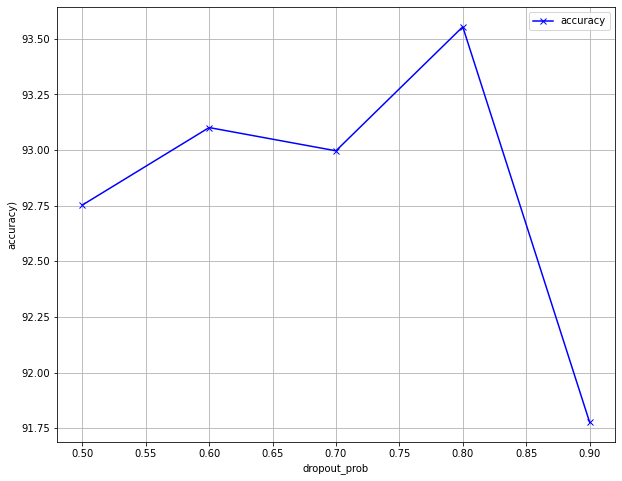

In [ ]:
from pylab import rcParams

# plot results
rcParams['figure.figsize'] = 10,8 # width 10, height 8

ax = accuracy_table.plot(x='dropout_prob', y='accuracy',style='bx-', grid=True)
#ax.set_xticklabels(param_list) # gave me an error when used
ax.set_xlabel("dropout_prob")
ax.set_ylabel("accuracy)")

In [ ]:
# Get optimum value for param
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
dropout_opt = temp[param_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(dropout_opt))

max Accuracy = 93.554
optimum dropout_prob = 0.8


In [ ]:

dropout_opt = 0.8
batch_size_opt = 8
epochs_opt = 5
optimizer_opt = 'SGD'


# **Collecting all optimum tuned parameters**

In [ ]:
d = {'param': ['optimizer', 'epochs', 'batch_size','dropout_prob'],
     'original': [optimizer_initial, epochs_initial, batchsize_initial,dropout_value_initial],
     'after_tuning': [optimizer_opt, epochs_opt, batch_size_opt,dropout_opt]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,optimizer,Adam,SGD
1,epochs,4,5
2,batch_size,8,8
3,dropout_prob,0.5,0.8


# **Creating the final model with optimum parameters**

In [ ]:
# get train and validation data generator
train_generator_opt,val_generator_opt,test_generator_opt = get_data_generator(train_dataset_path,validation_dataset_path,test_dataset_path, targetsize_constant, classmode_constant, batch_size_opt)

# load the base model
The_base_Model = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False)

# train and evaluate the model
accuracy, New_model = train_evaluate_the_model(train_generator_opt, val_generator_opt, optimizer_opt, epochs_opt,dropout_opt, The_base_Model)


Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


C:\Users\Student\anaconda_3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
358/358 [==============================] - 1023s 3s/step - loss: 1.1318 - accuracy: 0.6338 - val_loss: 0.5083 - val_accuracy: 0.7958
Epoch 2/5
358/358 [==============================] - 1050s 3s/step - loss: 0.5398 - accuracy: 0.7883 - val_loss: 0.3276 - val_accuracy: 0.8808
Epoch 3/5
358/358 [==============================] - 1040s 3s/step - loss: 0.4479 - accuracy: 0.8239 - val_loss: 0.3719 - val_accuracy: 0.8505
Epoch 4/5
358/358 [==============================] - 1040s 3s/step - loss: 0.3779 - accuracy: 0.8641 - val_loss: 0.2510 - val_accuracy: 0.9122
Epoch 5/5
359/359 [==============================] - 520s 1s/step - loss: 0.2036 - accuracy: 0.9230


In [ ]:
accuracy

92.29965209960938

# **Save the final model**

In [ ]:
New_model.save('brain_tumor_classification_VGG16_test1309.h5') 

# ---------------------------------------- END OF NOTEBOOK -------------------------------------
